In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
import numpy as np

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import os
import sys
from pathlib import Path
import IPython.display as ipd
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Plot.BodeDiagram import bode_diagram_gain

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

Operational transconductance amplifiers (OTA) are commonly used in synthesizer circuit. These devices enable controlling current from a control voltage. This is the same as if a variable resistor would be used. We have seen simuilar circuits with transistors in the RINGMODULATOR article. there are various circuits to create a voltage controllable devices. we habe seen the gilbert cell. there are also much better VCA circuits like the 2164. OTA's were commonly used in the past. It is still an accurate and cheap way to implement. There are not many OTA chips left on the market. A very good device is the LM1700, which is still an active device. 


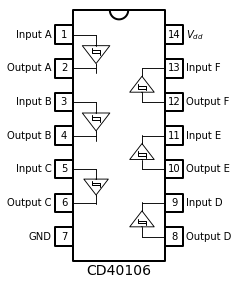

In [24]:
d = schemdraw.Drawing(lw=0.9)
d += (Q := elm.IcDIP(pins=14, botlabel='LM13700', lw=2)
             .label('Input A', loc='p1', fontsize=10)
             .label('Output A', loc='p2', fontsize=10)
             .label('Input B', loc='p3', fontsize=10)
             .label('Output B', loc='p4', fontsize=10)
             .label('Input C', loc='p5', fontsize=10)
             .label('Output C', loc='p6', fontsize=10)
             .label('GND', loc='p7', fontsize=10)

             .label('Output D', loc='p8', fontsize=10)
             .label('Input D', loc='p9', fontsize=10)
             .label('Output E', loc='p10', fontsize=10)
             .label('Input E', loc='p11', fontsize=10)
             .label('Output F', loc='p12', fontsize=10)
             .label('Input F', loc='p13', fontsize=10)
             .label('$V_{dd}$', loc='p14', fontsize=10))

d += elm.Line().at(Q.p1_in).length(d.unit/4)
d += (op := logic.Schmitt("down").toy(Q.p2_in).anchor('start').scale(.9))
d += elm.Line("right").at(Q.p2_in).length(d.unit/4)

d += elm.Line().at(Q.p3_in).length(d.unit/4)
d += (op := logic.Schmitt("down").toy(Q.p4_in).anchor('start').scale(.9))
d += elm.Line("right").at(Q.p4_in).length(d.unit/4)

d += elm.Line().at(Q.p5_in).length(d.unit/4)
d += (op := logic.Schmitt("down").toy(Q.p6_in).anchor('start').scale(.8))
d += elm.Line("right").at(Q.p6_in).length(d.unit/4)

d += elm.Line("left").at(Q.p8_in).length(d.unit/4)
d += (op := logic.Schmitt("up").toy(Q.p9_in).anchor('start').scale(.8))
d += elm.Line("left").at(Q.p9_in).length(d.unit/4)

d += elm.Line("left").at(Q.p10_in).length(d.unit/4)
d += (op := logic.Schmitt("up").toy(Q.p11_in).anchor('start').scale(.8))
d += elm.Line("left").at(Q.p11_in).length(d.unit/4)

d += elm.Line("left").at(Q.p12_in).length(d.unit/4)
d += (op := logic.Schmitt("up").toy(Q.p13_in).anchor('start').scale(.8))
d += elm.Line("left").at(Q.p13_in).length(d.unit/4)

d.draw()


the CD40106 device consist of six CMOS inverting schmitt-trigger circuits. this device is typically used in luneta circuits as a VCO. There are very interesting drone synth built with this chip. It is also used a timers and low pass filter sources in various circuits, for example the cynare module from Ken Stone.

the chip can be powered with GND and any positive supply from 5V-15V. The output amplitude will change with the positive supply voltage. The trigger values are documented in the datasheet on page xxx. For this exmapes the device is powered with GND/+5V and the trigger points are 1.9V/2.9V.


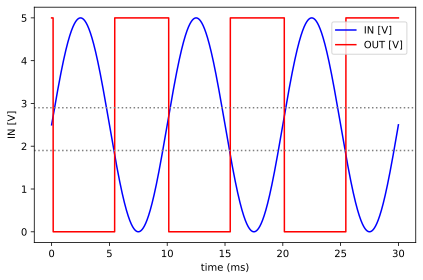

In [28]:
circuit = Circuit('cmos gate')
circuit.include(spice_library['4069UB'])
circuit.include(spice_library['CD40106B'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 2.5V SIN(2.5 2.5V 100)')

circuit.X('1', 'CD40106B', 'OUT', 'IN', '+5V', circuit.gnd)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=30@u_ms)

fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time (ms)')
ax1_buffer.set_ylabel('IN [V]')
ax1_buffer.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Blue')
ax1_buffer.plot(u_ms(analysis['OUT'].abscissa), analysis['OUT'], color='Red')
ax1_buffer.legend(('IN [V]', 'OUT [V]'), loc=(0.78,0.8))
ax1_buffer.axhline(y=1.9, color='Grey', linestyle='dotted')
ax1_buffer.axhline(y=2.9, color='Grey', linestyle='dotted')

plt.tight_layout()
plt.show()

# oscillator
{: class="subtitle is-lowercase"}

To build an oscillator with the schmitt trigger we need a capacitor and a resistor. the capcitor is placed at the input pin and is charged through the resistor until the schmitt trigger threshold is reached. The the output of the Schmitt Trigger goes to zero and the capacitor is discharged until the lower threshold is reached. this creates a square wave at the output pin.

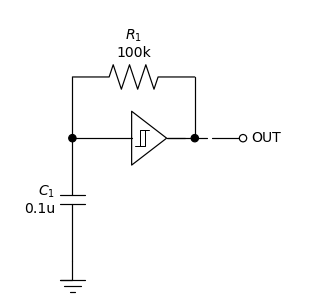

In [14]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.8, lw=1.2)
#d.add(elm.Dot('left', lftlabel='IN', open=True))
#d.add(elm.Line(l=d.unit/4))
N = d.add(logic.Schmitt().scale(1.1))

d.add(elm.Capacitor("down", at=N.start, label='$C_1$\n0.1u'))
d.add(elm.Ground)

d.add(logic.Dot(xy=N.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Resistor('right', label='$R_1$\n100k'))
d.add(elm.Line('down', l=d.unit/2))
d.add(logic.Dot())

d.add(elm.Line('right', l=d.unit/4, at=N.out))
d.add(elm.Dot(rgtlabel='OUT', open=True))

d.draw()

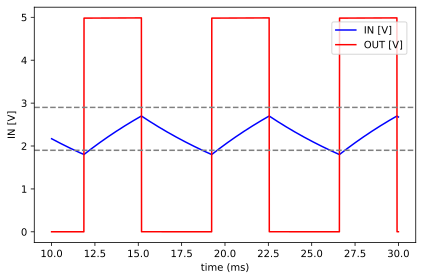

In [22]:
circuit = Circuit('cmos oscillator')
circuit.include(spice_library['4069UB'])
circuit.include(spice_library['CD40106B'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')

circuit.X('1', 'CD40106B', 'XOUT', 'IN', '+5V', circuit.gnd)
circuit.R(1, 'IN', 'XOUT', 100@u_kΩ)
circuit.C(1, 'IN', circuit.gnd, 0.1@u_uF)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.initial_condition(IN=0.0)
analysis  = simulator.transient(step_time=10@u_us, start_time=10@u_ms, end_time=30@u_ms)

fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time (ms)')
ax1_buffer.set_ylabel('IN [V]')
ax1_buffer.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Blue')
ax1_buffer.plot(u_ms(analysis['XOUT'].abscissa), analysis['XOUT'], color='Red')
ax1_buffer.legend(('IN [V]', 'OUT [V]'), loc=(0.78,0.8))
ax1_buffer.axhline(y=1.9, color='Grey', linestyle='dotted')
ax1_buffer.axhline(y=2.9, color='Grey', linestyle='dotted')

plt.tight_layout()
plt.show()

# voltage control
{: class="subtitle is-lowercase"}




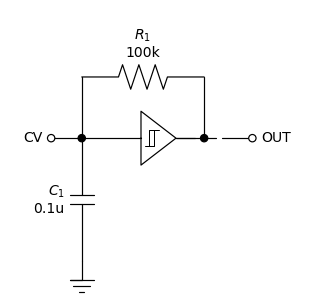

In [30]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.8, lw=1.2)
d.add(elm.Dot('left', lftlabel='CV', open=True))
d.add(elm.Line(l=d.unit/4))




N = d.add(logic.Schmitt().scale(1.1))

d.add(elm.Capacitor("down", at=N.start, label='$C_1$\n0.1u'))
d.add(elm.Ground)

d.add(logic.Dot(xy=N.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Resistor('right', label='$R_1$\n100k'))
d.add(elm.Line('down', l=d.unit/2))
d.add(logic.Dot())

d.add(elm.Line('right', l=d.unit/4, at=N.out))
d.add(elm.Dot(rgtlabel='OUT', open=True))

d.draw()

# ouput buffer
{: class="subtitle is-lowercase"}


of course we can just buffer the output with an opamp and adjust it to AC level. Ken Stone does a little bit more and at a first sight not so logical implemnetation of the output buffer.
 

The first OPAMP is just an inverting amplifier/mixer. All the inputs are connected with a 470kOhm Reistor. The feedback is a potentiometer with 100kOhm. This gives the maximum gain of x. The second opamp is a simple voltage follower, just buffering the signal. The potentiometer and capacitor between the opamps is called glide. Lets see what that does.


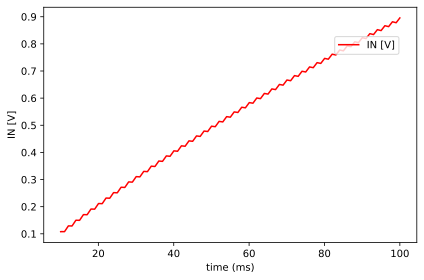

In [16]:
circuit = Circuit('cmos oscillator')
circuit.include(spice_library['TL072'])

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', '-15V', circuit.gnd, 'DC -15')
circuit.V('3', 'S1', circuit.gnd, 'DC 5 PULSE ( 0 5 1ms 0 0 1ms 2ms)')

circuit.X('1', 'TL072', circuit.gnd, 'X1n', '+15V', '-15V', 'Xout')
circuit.R(1, 'X1n', 'X1out', 100@u_kΩ)
circuit.R(2, 'S1', 'X1n', 470@u_kΩ)

circuit.R(3, 'X1out', 'R3', 470@u_kΩ)
circuit.C(1, 'R3', circuit.gnd, 220@u_nF)

circuit.X('2', 'TL072', 'R3', 'X2out', '+15V', '-15V', 'X2out')

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis  = simulator.transient(step_time=10@u_us, start_time=10@u_ms, end_time=100@u_ms)

fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time (ms)')
ax1_buffer.set_ylabel('IN [V]')
#ax1_buffer.plot(u_ms(analysis['S1'].abscissa), analysis['S1'], color='Blue')
ax1_buffer.plot(u_ms(analysis['X2out'].abscissa), analysis['X2out'], color='Red')
ax1_buffer.legend(('IN [V]', 'OUT [V]'), loc=(0.78,0.8))

plt.tight_layout()
plt.show()

# references
{: class="subtitle is-lowercase"}

1. [LM13700]() Datasheet
